In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from pathlib import Path
import kagglehub
from functools import lru_cache
from typing import Sequence, Literal
from math import log, isclose
import scipy.stats as st
import os

np.set_printoptions(suppress=True)

In [2]:
# import
dir_ = Path(kagglehub.dataset_download("mczielinski/bitcoin-historical-data"))
file_name = os.listdir(dir_)[0]
path = dir_ / file_name

print(f"Path to dataset: {path}")
raw_records = pd.read_csv(
    path,
    usecols=["Open", "High", "Low", "Close", "Volume"],
    #nrows=100_000
)
first_datetime = datetime.fromisoformat(pd.read_csv(path, nrows=1).loc[0, "datetime"])
print("Done")

Path to dataset: /Users/Misha/.cache/kagglehub/datasets/mczielinski/bitcoin-historical-data/versions/200/btcusd_1-min_data.csv
Done


In [3]:
# assigning a new index
datetime_index = pd.date_range(
    start=first_datetime,
    freq=timedelta(minutes=1),
    periods=len(raw_records)
)
records = raw_records
records.index = pd.Index(datetime_index, name="datetime")
records.rename(columns=str.lower, inplace=True)
records.tail()

,open,high,low,close,volume
datetime,,,,,
2025-03-16 04:36:00+00:00,82554.0,82554.0,82554.0,82554.0,0.072000
2025-03-16 04:37:00+00:00,82584.0,82615.0,82584.0,82615.0,0.194670
2025-03-16 04:38:00+00:00,82555.0,82555.0,82555.0,82555.0,0.002680
2025-03-16 04:39:00+00:00,82555.0,82555.0,82555.0,82555.0,0.000000
2025-03-16 04:40:00+00:00,82569.0,82569.0,82566.0,82566.0,0.003019


In [4]:
# groping
daily_records = records.resample("D", closed="right", label="right", origin="start").agg({
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
})
daily_records.index.name = "date"
daily_records.tail()

,open,high,low,close,volume
date,,,,,
2025-03-12 10:01:00+00:00,81325.0,83733.0,79031.0,82675.0,2339.022631
2025-03-13 10:01:00+00:00,82663.0,84437.0,80607.0,83405.0,2226.552840
2025-03-14 10:01:00+00:00,83409.0,83849.0,79910.0,82757.0,1627.976707
2025-03-15 10:01:00+00:00,82753.0,85294.0,82638.0,84328.0,1844.938637
2025-03-16 10:01:00+00:00,84330.0,85059.0,81983.0,82566.0,1039.123849


---
**If you held bitcoin for up to 30 days where would your profit lie?**

In [ ]:
# re-running the cell will clear all the cache!
@lru_cache
def profit_quantiles(
        close_prices: Sequence[float],
        max_span: int = 30,
        quantiles: Sequence[float | int] = (0.01, 0.25, 0.5, 0.75, 0.99),
) -> pd.DataFrame:
    return_of_hold = pd.DataFrame({k: 0.0 for k in quantiles}, index=range(1, max_span + 1))
    grouped = pd.Series(close_prices)

    for span in range(2, max_span + 1):
        res = (grouped
               .rolling(window=span)
               .apply(lambda srs: (srs.iat[-1] / srs.iat[0] - 1) * 100)
               .quantile(quantiles)
               )
        return_of_hold.loc[span] = res
    return return_of_hold

In [ ]:
# calculate the profit
MAX_SPAN_DAYS = 100
QUANTILES = (0.01, 0.25, 0.5, 0.75, 0.99)

return_of_hold = profit_quantiles(
    close_prices=tuple(daily_records["close"]),  # bad practice. todo: look for a better solution
    max_span=MAX_SPAN_DAYS,
    quantiles=QUANTILES
)
return_of_hold.tail()

In [ ]:
# charting
ax = plt.subplot()
for quantile, data in return_of_hold.items():
    if data.iat[-1] < 0:
        color = "red"
    elif data.iat[-1] == 0:
        color = "grey"
    else:
        color = "green"

    ax.plot(data, color=color)
    ax.text(x=MAX_SPAN_DAYS * 1.02, y=data.iat[-1], s=f"Q {round(quantile, 4)} = {round(data.iat[-1], 2)}%",
            color=color)

ax.axhline(0, linestyle="dashed", color="grey")

ax.set_title("Quantiles of return against days held")
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel("Days held")
ax.set_xlim(1, MAX_SPAN_DAYS * 1.01)

ax.set_yticks(
    np.arange(return_of_hold.min(axis=None) * 0.9, return_of_hold.max(axis=None) * 1.1,
              return_of_hold.mean(axis=None) * 3).round(2)
)
ax.set_ylabel("Return in %")
print(f"The profit will generally be positive with the 50% chance of it being between "
      f"{return_of_hold.iloc[-1, 1].round(2)}% and {return_of_hold.iloc[-1, 3].round(2)}%, "
      f"with median profit being {return_of_hold.iloc[-1, 2].round(2)}%")

---
**Did Bitcoin become more or less volatile over the years?**

In [56]:
weekly_grouped = daily_records.resample("W-MON")
weekly_cv = weekly_grouped.std() / weekly_grouped.mean()
close_cv = weekly_cv["close"].ewm(alpha=0.1).mean()

Bitcoin became less volative over the years, which may have been caused by bigger addoption of the coin and can lead it further cementing its image as the "digital gold".


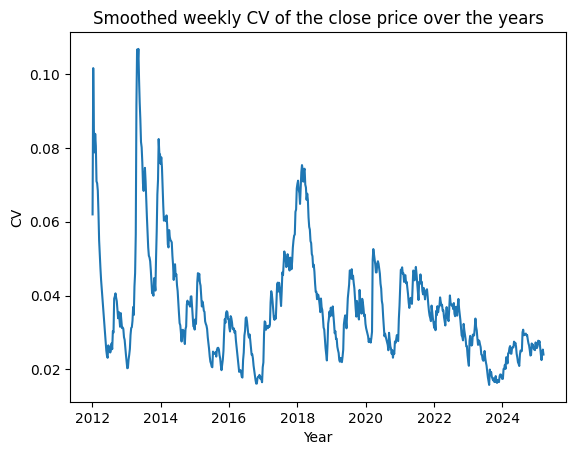

In [62]:
ax = plt.subplot()
ax.plot(close_cv)
ax.set_ylabel("CV")
ax.set_xlabel("Year")
ax.set_title("Smoothed weekly CV of the close price over the years")
print("Bitcoin became less volative over the years, which may have been caused by bigger addoption of the coin and can lead it further cementing its image as the \"digital gold\".")

---
**EMA-Cross autoregression model**

In [25]:
ALPHA_SLOW = 0.04
ALPHA_FAST = 0.2

ema_slow = pd.Series(records["close"].ewm(alpha=ALPHA_SLOW).mean(), name="ema_slow")
ema_fast = pd.Series(records["close"].ewm(alpha=ALPHA_FAST).mean(), name="ema_fast")

In [39]:
class Trader:
    def __init__(self,
                 volume_quartile: float,
                 rel_tol_out=0.05,
                 rel_tol_in=0.03
                 ):
        """
        :param rel_tol_out: outer relative tolerance to start a trade
        :param rel_tol_in: inner relative tolerance to end a trade
        :param volume_quartile: Q-0.25 of the traded volume
        :return: None
        """
        self.volume_quartile = volume_quartile
        self.rel_tol_in = rel_tol_in
        self.rel_tol_out = rel_tol_out
        self.in_trade: bool = False
        self.trade_type: Literal["long", "short"] | None = None
        self.trade_id: int = 0

        columns = pd.MultiIndex.from_tuples([
            ("trade_entry", "datetime"),
            ("trade_entry", "price"),
            ("trade_exit", "datetime"),
            ("trade_exit", "price"),
            ("trade_type", "type")
        ])
        self._trade_list: pd.DataFrame = pd.DataFrame(columns=columns)
        self._trade_list.index.name = "trade_id"
        return

    def _log_trade(
            self,
            trade_id: int,
            trade_type: Literal["long", "short"] | None = None,
            trade_entry_datetime: datetime | None = None,
            trade_entry_price: float | None = None,
            trade_exit_datetime: datetime | None = None,
            trade_exit_price: float | None = None
    ) -> None:
        assert type(trade_id) is int, "trade_id must be an integer"

        if trade_type:
            self._trade_list.loc[trade_id, (trade_type, "type")] = trade_type

        if trade_entry_datetime:
            self._trade_list.loc[trade_id, ("trade_entry", "datetime")] = trade_entry_datetime

        if trade_entry_price:
            self._trade_list.loc[trade_id, ("trade_entry", "price")] = trade_entry_price

        if trade_exit_datetime:
            self._trade_list.loc[trade_id, ("trade_exit", "datetime")] = trade_exit_datetime

        if trade_exit_price:
            self._trade_list.loc[trade_id, ("trade_exit", "price")] = trade_exit_price

        return

    @property
    def trade_list(self) -> pd.DataFrame:
        trade_list = self._trade_list.astype({
            ("trade_entry", "price"): float,
            ("trade_entry", "datetime"): "datetime64[ns, UTC]",
            ("trade_exit", "price"): float,
            ("trade_exit", "datetime"): "datetime64[ns, UTC]",
            ("trade_type", "type"): "category"
        })
        return trade_list

    def trade(self, row: pd.Series):
        # row must have the following indices:
        # "open", "high", "low", "close", "volume", "ema_fast", "ema_slow"

        if (
                (row.isna().any()) or  # some values are invalid
                (not isclose(row["ema_fast"], row["ema_slow"], rel_tol=self.rel_tol_out)) or  # ema's are far apart
                (row["volume"] < self.volume_quartile)  # to little volume to trade
        ):
            return row

        ema_fast: float = row.loc["ema_fast"]
        ema_slow: float = row.loc["ema_slow"]
        volume = row.loc["volume"]
        record: pd.Series = row.loc[["open", "high", "low", "close"]]

        # attempt to open a trade
        if all([
            not self.in_trade,
            not isclose(ema_fast, ema_slow, rel_tol=self.rel_tol_out),
            volume > self.volume_quartile
        ]):
            self.in_trade = True
            self.trade_type = "long" if ema_fast > ema_slow else "short"
            self.trade_id += 1

            self._log_trade(
                trade_id=self.trade_id,
                trade_type=self.trade_type,
                trade_entry_datetime=record.name,
                trade_entry_price=record.loc["close"],
            )

        # attempt to close a trade
        if self.in_trade and isclose(ema_fast, ema_slow, rel_tol=self.rel_tol_in):
            self._log_trade(
                trade_id=self.trade_id,
                trade_exit_datetime=record.name,
                trade_exit_price=record.loc["close"]
            )
            self.in_trade = False
            self.trade_type = None

        return row

In [35]:
trader = Trader(rel_tol_in=0.01, rel_tol_out=0.03, volume_quartile=records["volume"].quantile(0.25))
data = pd.concat([records.iloc[:500_000], ema_fast.iloc[:500_000], ema_slow.iloc[:500_000]], axis="columns")
data.dropna(inplace=True)

In [37]:
data.transform(trader.trade, axis="columns");

In [36]:
data = data.resample("5min").agg({
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum",
    "ema_fast": "mean",
    "ema_slow": "mean",
})

In [38]:
trader.trade_list

Empty DataFrame
Columns: [(trade_entry, datetime), (trade_entry, price), (trade_exit, datetime), (trade_exit, price), (trade_type, type)]
Index: []

---
**How does price change correlate with change of trading volume?**

In [31]:
QUANTILES = [0.05, 0.95]

volume_change = daily_records["volume"].pct_change().dropna()
price_change = daily_records["close"] / daily_records["open"] - 1

price_volume_change = pd.concat([volume_change, price_change], axis="columns")
price_volume_change.rename(columns={"volume": "volume_change", 0: "price_change"}, inplace=True)

mask = price_volume_change.isin([np.nan, np.inf, -np.inf])
price_volume_change[mask] = 0

# filtering out the outliers
volume_mask = pd.qcut(price_volume_change["volume_change"], q=QUANTILES).isna().to_numpy()
price_mask = pd.qcut(price_volume_change["price_change"], q=QUANTILES).isna().to_numpy()

general_mask = np.stack([volume_mask, price_mask], axis=1).any(axis=1)

indices_to_drop = price_volume_change.loc[general_mask].index
price_volume_change.drop(indices_to_drop, inplace=True)

spearman = (st.spearmanr(a=price_volume_change["price_change"], b=price_volume_change["volume_change"])
            .statistic
            .round(4)
            )

price_volume_change.tail()

,volume_change,price_change
date,,
2025-03-12 10:01:00+00:00,-0.277108,0.016600
2025-03-13 10:01:00+00:00,-0.048084,0.008976
2025-03-14 10:01:00+00:00,-0.268835,-0.007817
2025-03-15 10:01:00+00:00,0.133271,0.019033
2025-03-16 10:01:00+00:00,-0.436771,-0.020918


Spearman rank correlation coefficient: 0.0089
There is practically no correlation between these two values.


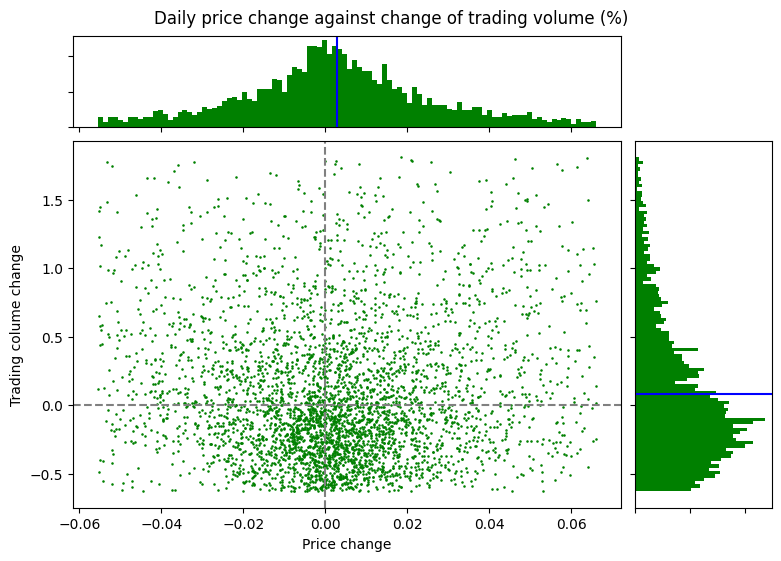

In [109]:
# charting
fig, axs = plt.subplot_mosaic([['histx', '.'],
                               ['scatter', 'histy']],
                              figsize=(7.7, 5.5),
                              width_ratios=(4, 1), 
                              height_ratios=(1, 4),
                              layout='constrained')

ax_histx, ax, ax_histy = axs.values()

BIN_NUMBER = 100

fig.suptitle("Daily price change against change of trading volume (%)")

# scatter plot stuff >>>>>>>
ax.scatter(
    x=price_volume_change["price_change"],
    y=price_volume_change["volume_change"],
    s=0.7,
    color="green"
)

ax.axvline(x=0, linestyle="dashed", color="grey")
ax.axhline(y=0, linestyle="dashed", color="grey")

ax.set_ylabel("Trading colume change")
ax.set_xlabel("Price change")
# <<<<<<<

# histogram on x >>>>>>>
ax_histx.hist(
    price_volume_change["price_change"], 
    bins=BIN_NUMBER,
    color="green"
)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.tick_params(axis="y", labelleft=False)
ax_histx.axvline(price_volume_change["price_change"].mean(), color="blue")
# <<<<<<<

# histogram on y >>>>>>>
ax_histy.hist(
    price_volume_change["volume_change"], 
    bins=BIN_NUMBER,
    color="green",
    orientation='horizontal'
)
ax_histy.tick_params(axis="y", labelbottom=False, labelleft=False)
ax_histy.tick_params(axis="x", labelbottom=False)
ax_histy.axhline(price_volume_change["volume_change"].mean(), color="blue")
# <<<<<<<

print(f"Spearman rank correlation coefficient: {spearman}")
print("There is practically no correlation between these two values.")

---
**How does halving affect price and trading volume?**

In [ ]:
halving_dates = (
    date(year=2012, month=11, day=28),
    date(year=2016, month=7, day=9),
    date(year=2020, month=7, day=10),
    date(year=2024, month=4, day=20),
)

grouped = (records
           .resample("ME")
           .agg({"close": "median", "volume": "sum"})
           .reset_index(drop=True)
           )
grouped.index = pd.date_range(start=first_datetime, freq=timedelta(days=30), periods=len(grouped))

In [ ]:
ax = plt.subplot()
ax.plot(grouped["close"].map(log), color="blue")
ax.set_title("Bitcoin price development after each halving")
ax.set_xlabel("Year")
ax.set_ylabel("Log price in $")

for date in halving_dates:
    ax.axvline(x=date, linestyle="dashed", color="green", label="halving date")

ax.legend(ax.get_children()[:2], ["Log price", "Halving"])
print("There used to be a visible correlation between the halving and a significat price jump.\n"
      "In the 2024 this jump is however much smaller than other times")

---
**How did trading volume per dollar change over the years?**

In [ ]:
grouped = (records
           .resample("ME")
           .agg({"close": "median", "volume": "sum"})
           .reset_index(drop=True)
           )
grouped.index = pd.date_range(start=first_datetime, freq=timedelta(days=30), periods=len(grouped))
volume_per_dollar = grouped["volume"] / grouped["close"]

In [ ]:
ax = plt.subplot()

ax.plot(volume_per_dollar.map(log), color="green")
ax.set_ylabel("Log Trading volume per dollar")
ax.set_xlabel("Year")
ax.set_title("Trading volume per dollar price over time");
print("Sinking trading volume per dollar is a signal of the price growing faster than the trading volume.\n"
      "This in turn may imply that the Bitcoin has become much more of a speculation tool than a real valuable asset.")